In [2]:
#!pip install pandas matplotlib seaborn scikit-learn numpy imblearn xgboost shap -q

In [3]:
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
# --- 1. Setup ---
INPUT_FILE = 'atendimentos_de_alunos_processado.csv'
OUTPUT_FILE = 'atendimentos_de_alunos_machine_learning.csv'

# Columns to remove
COLUMNS_TO_DROP = [
    'Grupo_percent_Cursado', 'MATRICULAID', '1º_NOME', 'DATAMATRICULA',
    'Data_de_nascimento', 'ENCERRAMENTO_CONTRATO',
    'DATAMATRICULA_is_missing', 'ENCERRAMENTO_CONTRATO_is_missing', 'PercentualConclusao',
    'Data_de_nascimento_is_missing', 'Situação_Contrato'
]

# Define exceptions for boolean conversion
# These columns will be treated as numeric and scaled, even if they only contain 0s and 1s.
BOOLEAN_CONVERSION_EXCEPTIONS = [
    'Correção_-_Plataforma', 'Ouvidoria', 'Processos_Secretaria', 'Suporte_Pedagogico'
]


# --- 2. Processing Pipeline ---
# Load data and clean column names in one go

df = pd.read_csv(INPUT_FILE, sep=';')

df.columns = (df.columns.str.strip().str.replace(' ', '_', regex=False).str.replace('%', 'percent', regex=False).str.replace('#', 'num', regex=False))


# Drop duplicate rows based on 'MATRICULAID', keeping the first occurrence
if 'MATRICULAID' in df.columns:
    df = df.drop_duplicates(subset='MATRICULAID', keep='first')

# Drop irrelevant columns
df.drop(columns=COLUMNS_TO_DROP, inplace=True, errors='ignore')

# Convert percentage columns to float
for col in ['percent_Docs_Pessoais']:
    if col in df.columns:
        df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Identify and convert binary (0/1) numeric columns to boolean, respecting exceptions
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
binary_cols = []
for col in numeric_cols:
    # Check if the column contains only 0s and 1s AND is NOT in the exception list
    is_binary = df[col].dropna().isin([0, 1]).all()
    if is_binary and col not in BOOLEAN_CONVERSION_EXCEPTIONS:
        binary_cols.append(col)

if binary_cols:
    df[binary_cols] = df[binary_cols].astype(bool)

# Identify remaining numeric columns for scaling (this will now include the exceptions)
cols_to_scale = [col for col in numeric_cols if col not in binary_cols]

# Scale the remaining numeric columns
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# One-hot encode the remaining categorical columns
df_processed = pd.get_dummies(df, drop_first=True)

# Convert 'churn' column back to integer (1 and 0)
if 'churn' in df_processed.columns:
    df_processed['churn'] = df_processed['churn'].astype(int)


# --- 3. Save the Result ---
df_processed.to_csv(OUTPUT_FILE, index=False, sep=';')

In [5]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(OUTPUT_FILE, sep=';')

# Define features (X) and target (y)

X = df.drop('churn', axis=1)
y = df['churn']

# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train and validation (from X_temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (9200, 153)
Validation shape: (2301, 153)
Test shape: (2876, 153)


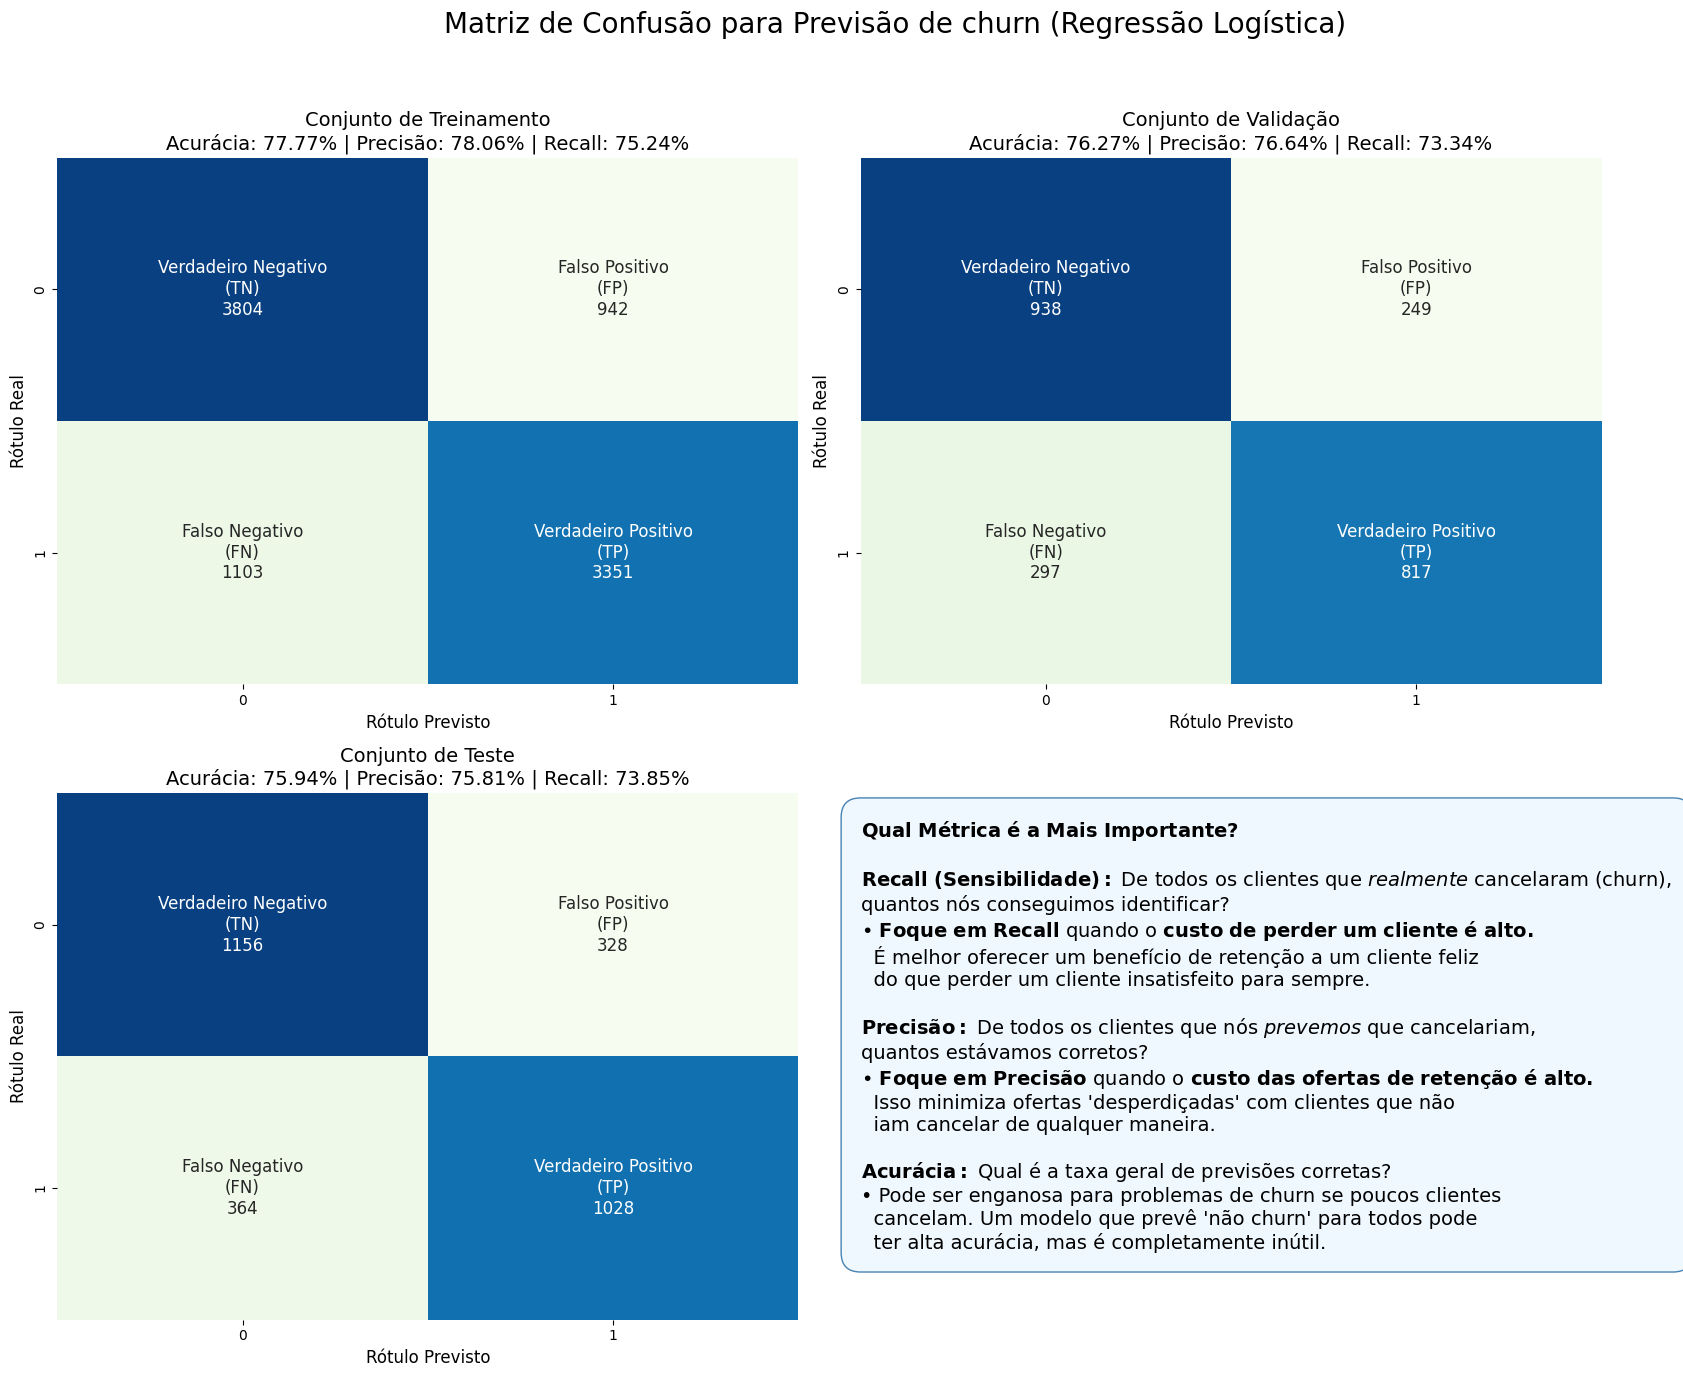

In [6]:
# --- Dimensionamento de Features (Feature Scaling) ---

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Treinamento do Modelo ---

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# --- Previsões ---

y_train_pred = log_reg.predict(X_train_scaled)
y_val_pred = log_reg.predict(X_val_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# --- Função de Plotagem para uma Única Matriz ---

def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plota uma única matriz de confusão anotada em um determinado eixo do matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calcular métricas
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Criar os textos dos rótulos para cada célula
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])

    # Plotar o mapa de calor (heatmap)
    sns.heatmap(cm, annot=labels, fmt='', cmap='GnBu', cbar=False, ax=ax, annot_kws={"size": 12})

    # Definir títulos e rótulos
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criar a Imagem Consolidada ---

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Matriz de Confusão para Previsão de churn (Regressão Logística)', fontsize=20, y=0.98)

# Achata o array de eixos para facilitar a iteração se necessário, mas o acesso direto é suficiente
axes = axes.ravel()

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Adicionar Texto Explicativo ao Quarto Subplot ---

ax_text = axes[3]
ax_text.axis('off')  # Oculta os eixos

# Conteúdo do texto
text_content = (
    r"$\bf{Qual\ Métrica\ é\ a\ Mais\ Importante?}$" "\n\n"
    r"$\bf{Recall\ (Sensibilidade):}$" " De todos os clientes que " r"$\it{realmente}$" " cancelaram (churn), \n"
    "quantos nós conseguimos identificar? \n"
    "• " r"$\bf{Foque\ em\ Recall}$" " quando o " r"$\bf{custo\ de\ perder\ um\ cliente\ é\ alto.}$" "\n"
    "  É melhor oferecer um benefício de retenção a um cliente feliz \n"
    "  do que perder um cliente insatisfeito para sempre."
    "\n\n"
    r"$\bf{Precisão:}$" " De todos os clientes que nós " r"$\it{prevemos}$" " que cancelariam, \n"
    "quantos estávamos corretos? \n"
    "• " r"$\bf{Foque\ em\ Precisão}$" " quando o " r"$\bf{custo\ das\ ofertas\ de\ retenção\ é\ alto.}$" "\n"
    "  Isso minimiza ofertas 'desperdiçadas' com clientes que não \n"
    "  iam cancelar de qualquer maneira."
    "\n\n"
    r"$\bf{Acurácia:}$" " Qual é a taxa geral de previsões corretas? \n"
    "• Pode ser enganosa para problemas de churn se poucos clientes \n"
    "  cancelam. Um modelo que prevê 'não churn' para todos pode \n"
    "  ter alta acurácia, mas é completamente inútil."
)

# Adicionar o texto ao plot
ax_text.text(
    0.0, 0.95, text_content,
    ha='left', va='top', fontsize=14,
    wrap=True,
    bbox=dict(boxstyle='round,pad=1', fc='aliceblue', ec='steelblue')
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/tmp/ipykernel_5136/1752338204.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


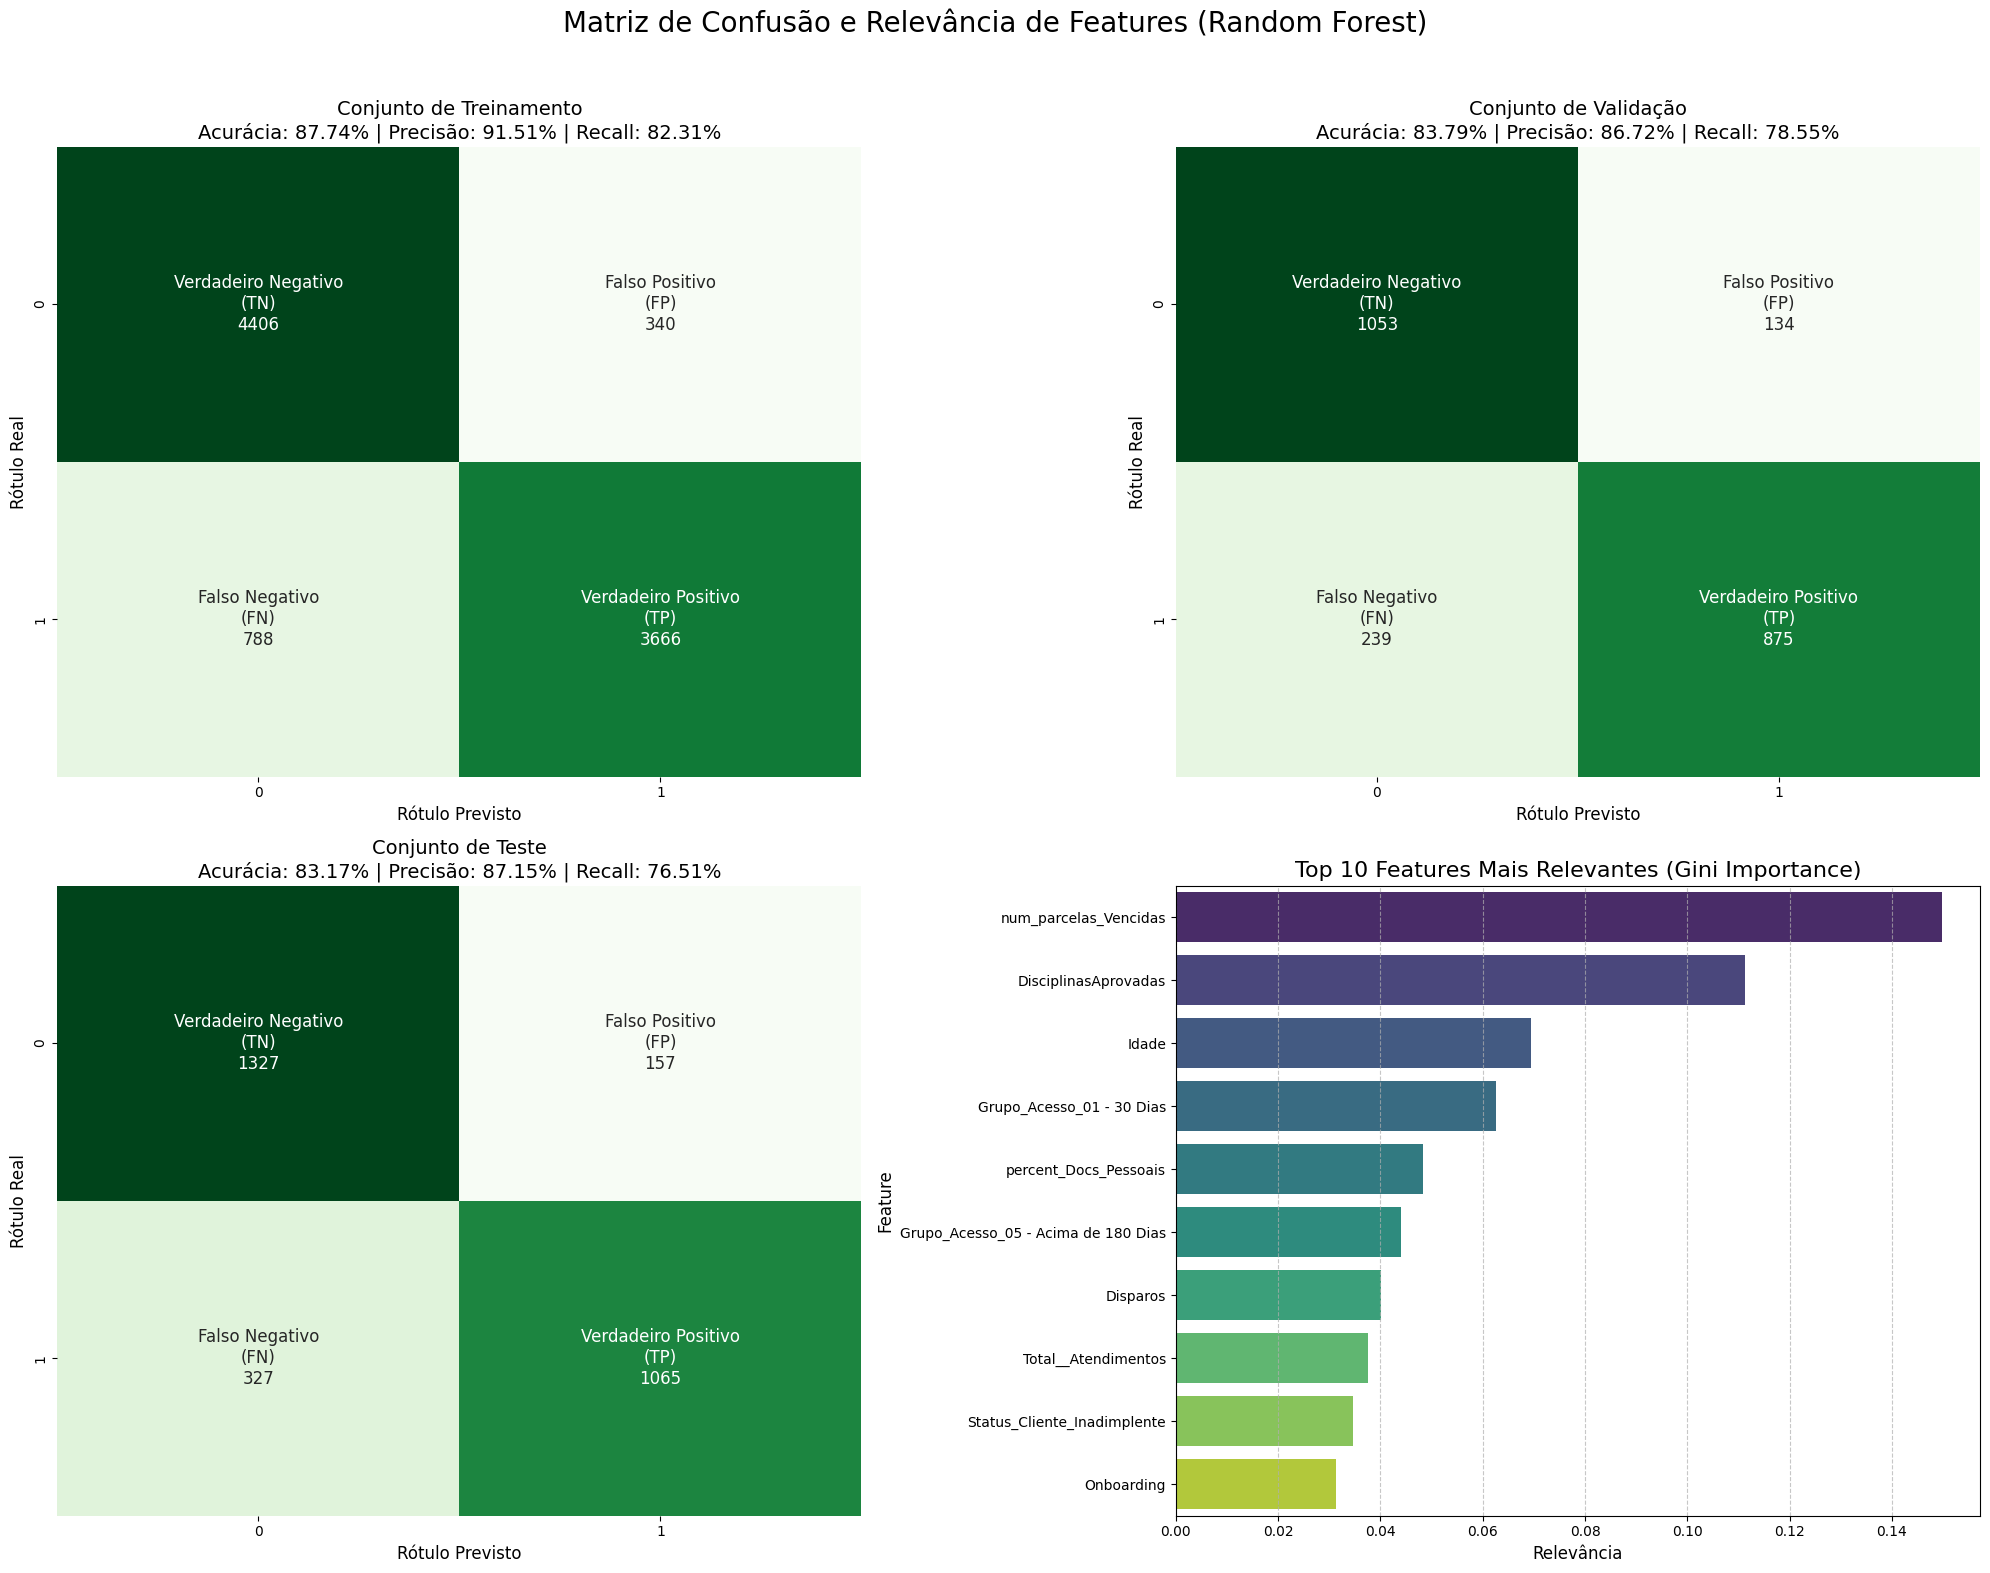

In [7]:
# --- Dimensionamento de Features (Feature Scaling) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Treinamento do Modelo (Random Forest) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# --- Previsões ---
y_train_pred = rf_model.predict(X_train_scaled)
y_val_pred = rf_model.predict(X_val_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# --- Função de Plotagem para uma Única Matriz ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plota uma única matriz de confusão anotada em um determinado eixo do matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.\nVerifique os rótulos y_true e y_pred.', 
                ha='center', va='center', fontsize=10)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return
        
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens', cbar=False, ax=ax, annot_kws={"size": 12})
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criar a Imagem Consolidada ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Matriz de Confusão e Relevância de Features (Random Forest)', fontsize=20, y=0.98)
axes = axes.ravel()

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features (Feature Importance) ---
ax_importance = axes[3]
importances = rf_model.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# --- MODIFICAÇÃO AQUI ---
# Criar o gráfico de barras com as 10 features mais importantes
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(10), # Seleciona apenas as 10 primeiras linhas
    ax=ax_importance, 
    palette='viridis'
)

# Ajustar o título para refletir a mudança
ax_importance.set_title('Top 10 Features Mais Relevantes (Gini Importance)', fontsize=16)
ax_importance.set_xlabel('Relevância', fontsize=12)
ax_importance.set_ylabel('Feature', fontsize=12)
ax_importance.grid(axis='x', linestyle='--', alpha=0.7)

# Ajustar o layout e exibir o gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Gerando a visualização da Árvore de Decisão...


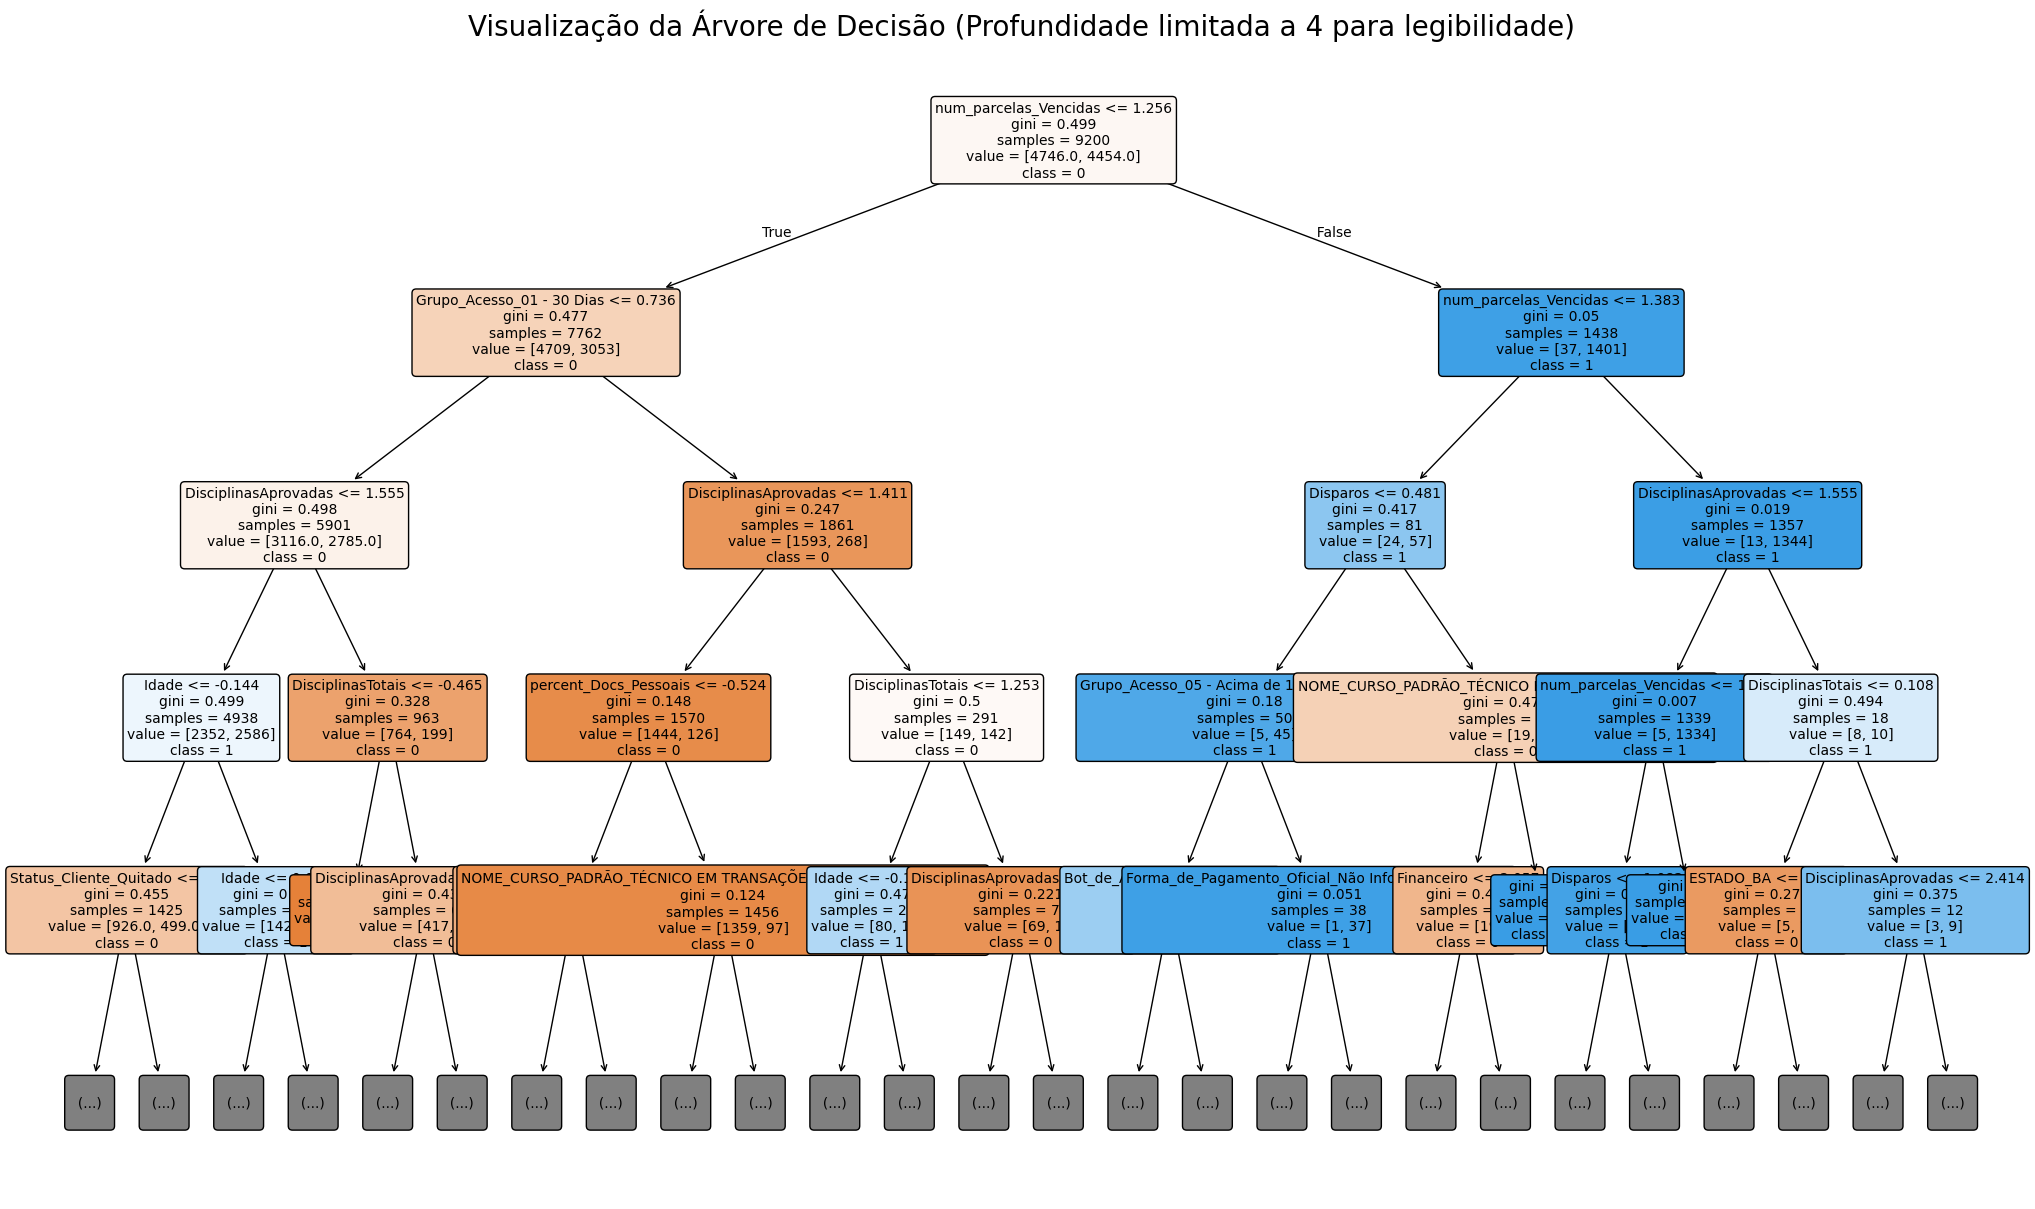


Visualização da matriz de confusão e relevância de features (como antes):


/tmp/ipykernel_5136/2908582033.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), ax=ax_importance, palette='Reds')


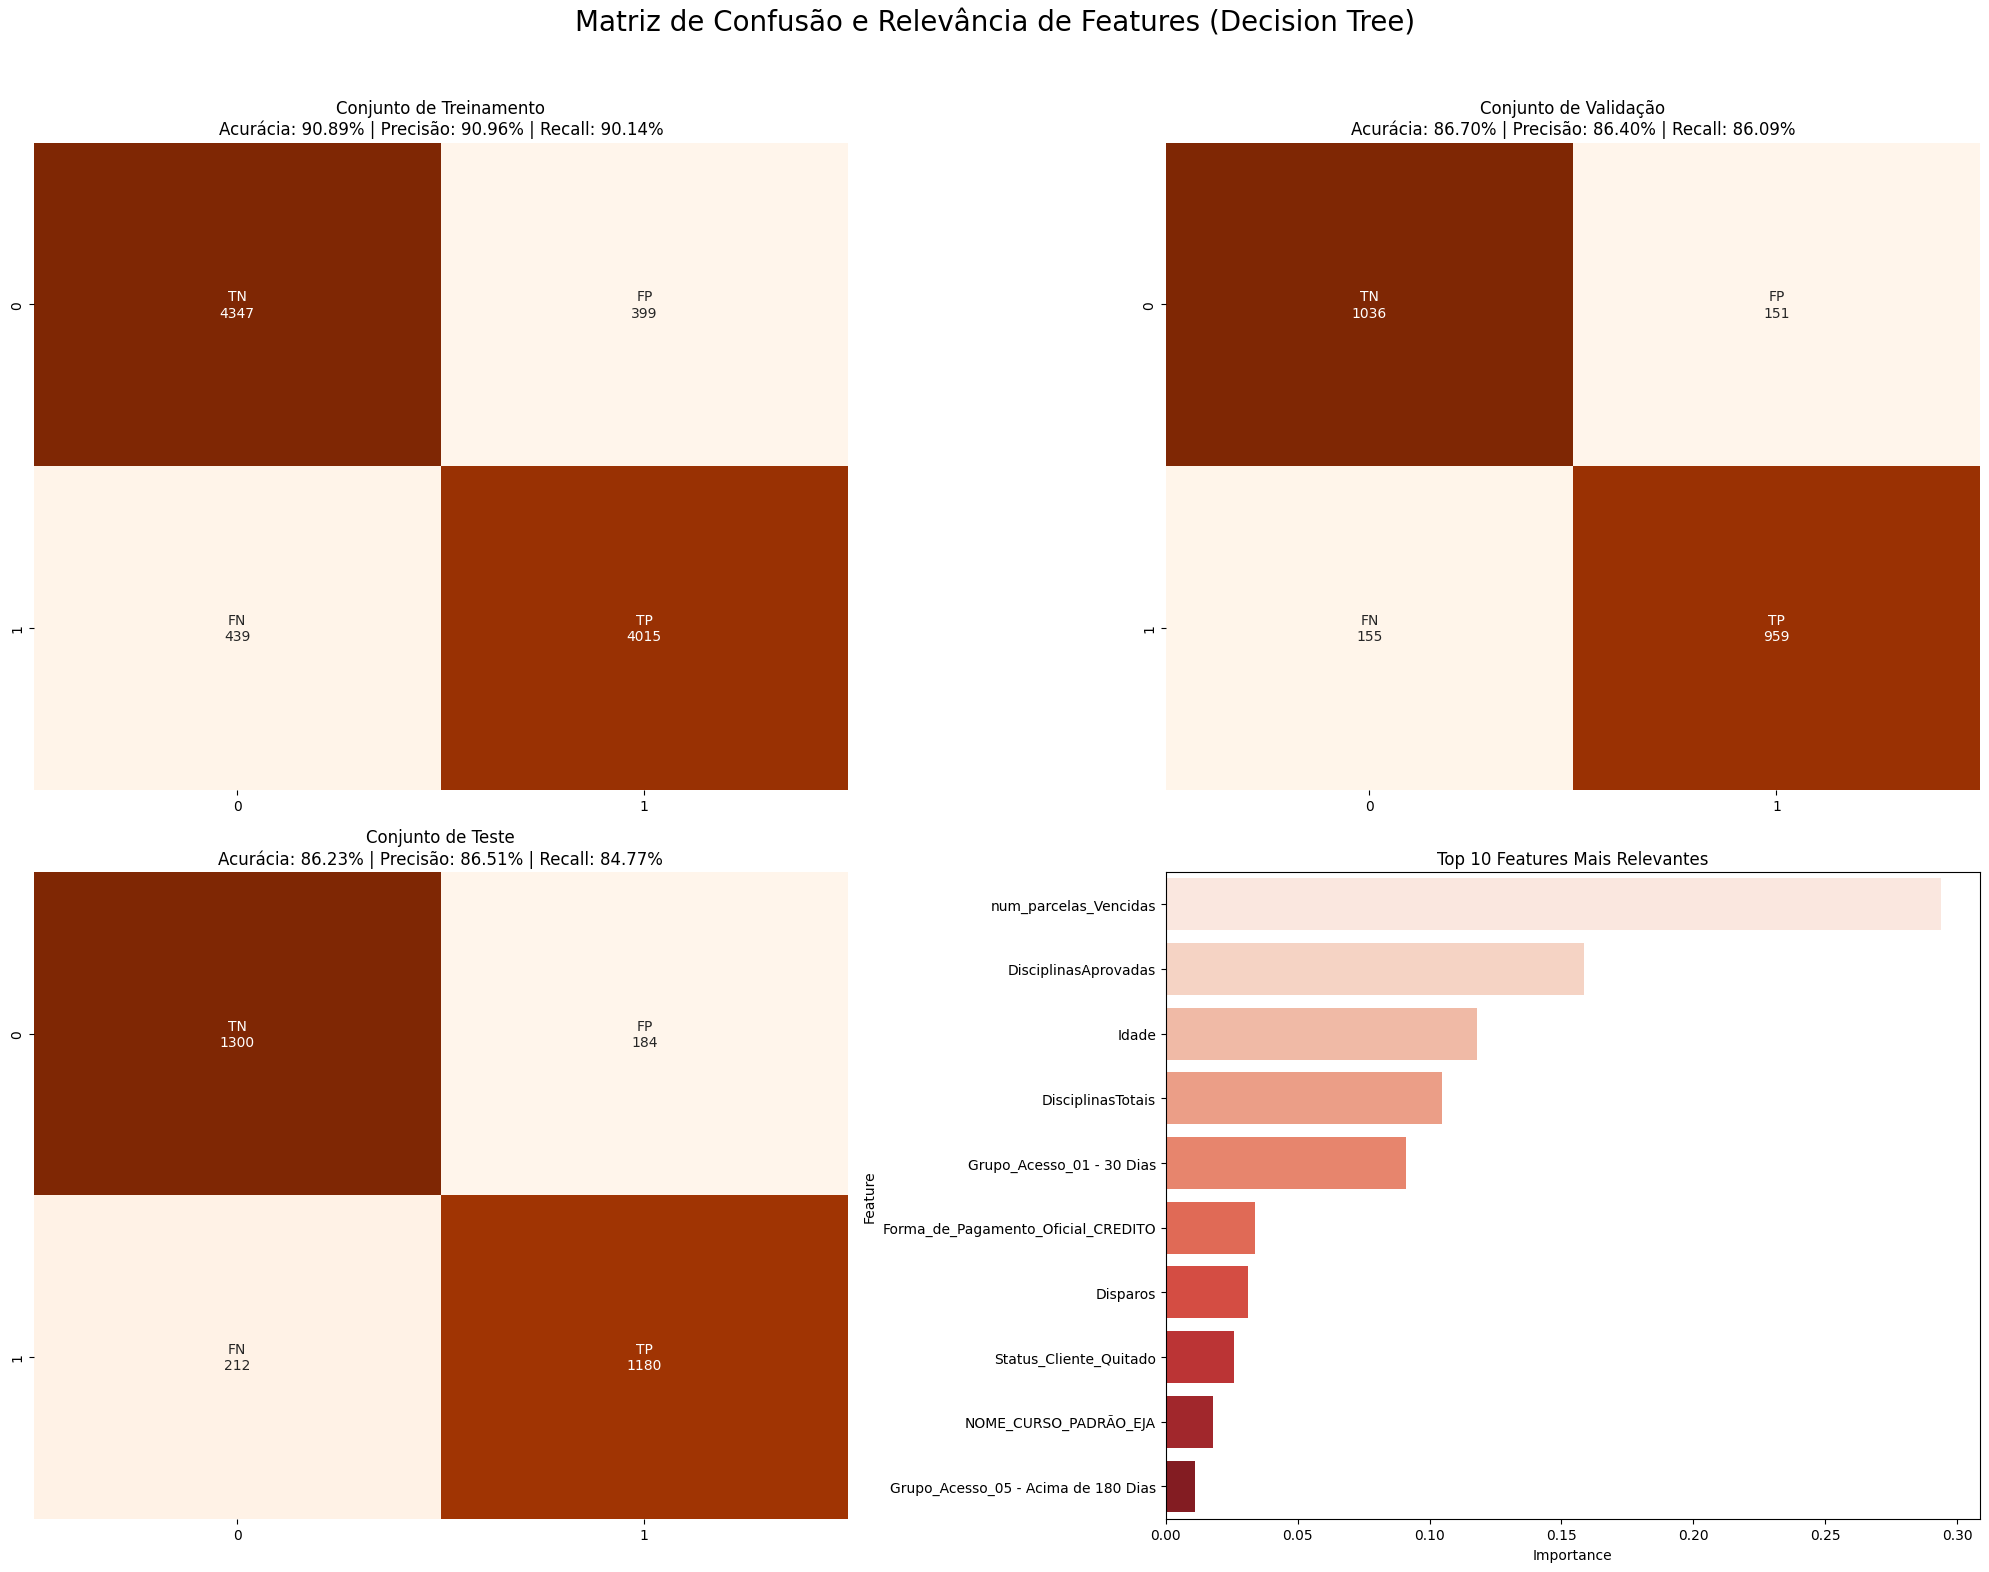

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree # Importa a função plot_tree
from sklearn.metrics import confusion_matrix

# Supondo que os dados X_train, y_train, X_val, y_val, X_test, y_test já existem
# Descomente as linhas abaixo se precisar gerar dados de exemplo:
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=42)
# X = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(20)])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# --- Dimensionamento de Features (Feature Scaling) ---
scaler = StandardScaler()
# Garantir que X_train seja um DataFrame para obter os nomes das colunas
X_train_df = pd.DataFrame(X_train, columns=getattr(X_train, 'columns', [f'Feature_{i}' for i in range(X_train.shape[1])]))

X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Treinamento do Modelo (Decision Tree) ---
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train_scaled, y_train)

# --- Visualização da Árvore de Decisão ---
print("Gerando a visualização da Árvore de Decisão...")

# Define os nomes das features e das classes para a visualização
feature_names = X_train_df.columns.tolist()
class_names = [str(c) for c in np.unique(y_train)] # Nomes das classes (ex: ['0', '1'])

# Cria uma figura grande para acomodar a árvore
plt.figure(figsize=(25, 15))

# Plota a árvore de decisão
plot_tree(
    dt_model,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,  # Colore os nós para indicar a classe majoritária
    rounded=True, # Usa caixas de nós arredondadas
    fontsize=10,  # Tamanho da fonte
    max_depth=4   # Limita a profundidade da visualização para ser mais legível
)

# Adiciona um título e exibe o gráfico
plt.title("Visualização da Árvore de Decisão (Profundidade limitada a 4 para legibilidade)", fontsize=20)
plt.show()

print("\nVisualização da matriz de confusão e relevância de features (como antes):")

# O código para as matrizes de confusão e relevância das features permanece o mesmo
# --- Criar a Imagem Consolidada ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Matriz de Confusão e Relevância de Features (Decision Tree)', fontsize=20, y=0.98)
axes = axes.ravel()

y_train_pred = dt_model.predict(X_train_scaled)
y_val_pred = dt_model.predict(X_val_scaled)
y_test_pred = dt_model.predict(X_test_scaled)

# --- Função de Plotagem para uma Única Matriz ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.', ha='center', va='center')
        ax.set_title(title)
        return
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    labels = np.array([[f'TN\n{tn}', f'FP\n{fp}'], [f'FN\n{fn}', f'TP\n{tp}']])
    sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', cbar=False, ax=ax)
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}')

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features ---
ax_importance = axes[3]
importances = dt_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), ax=ax_importance, palette='Reds')
ax_importance.set_title('Top 10 Features Mais Relevantes')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Iniciando o treinamento do modelo LinearSVC...
Treinamento concluído.


/tmp/ipykernel_5136/1397794929.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


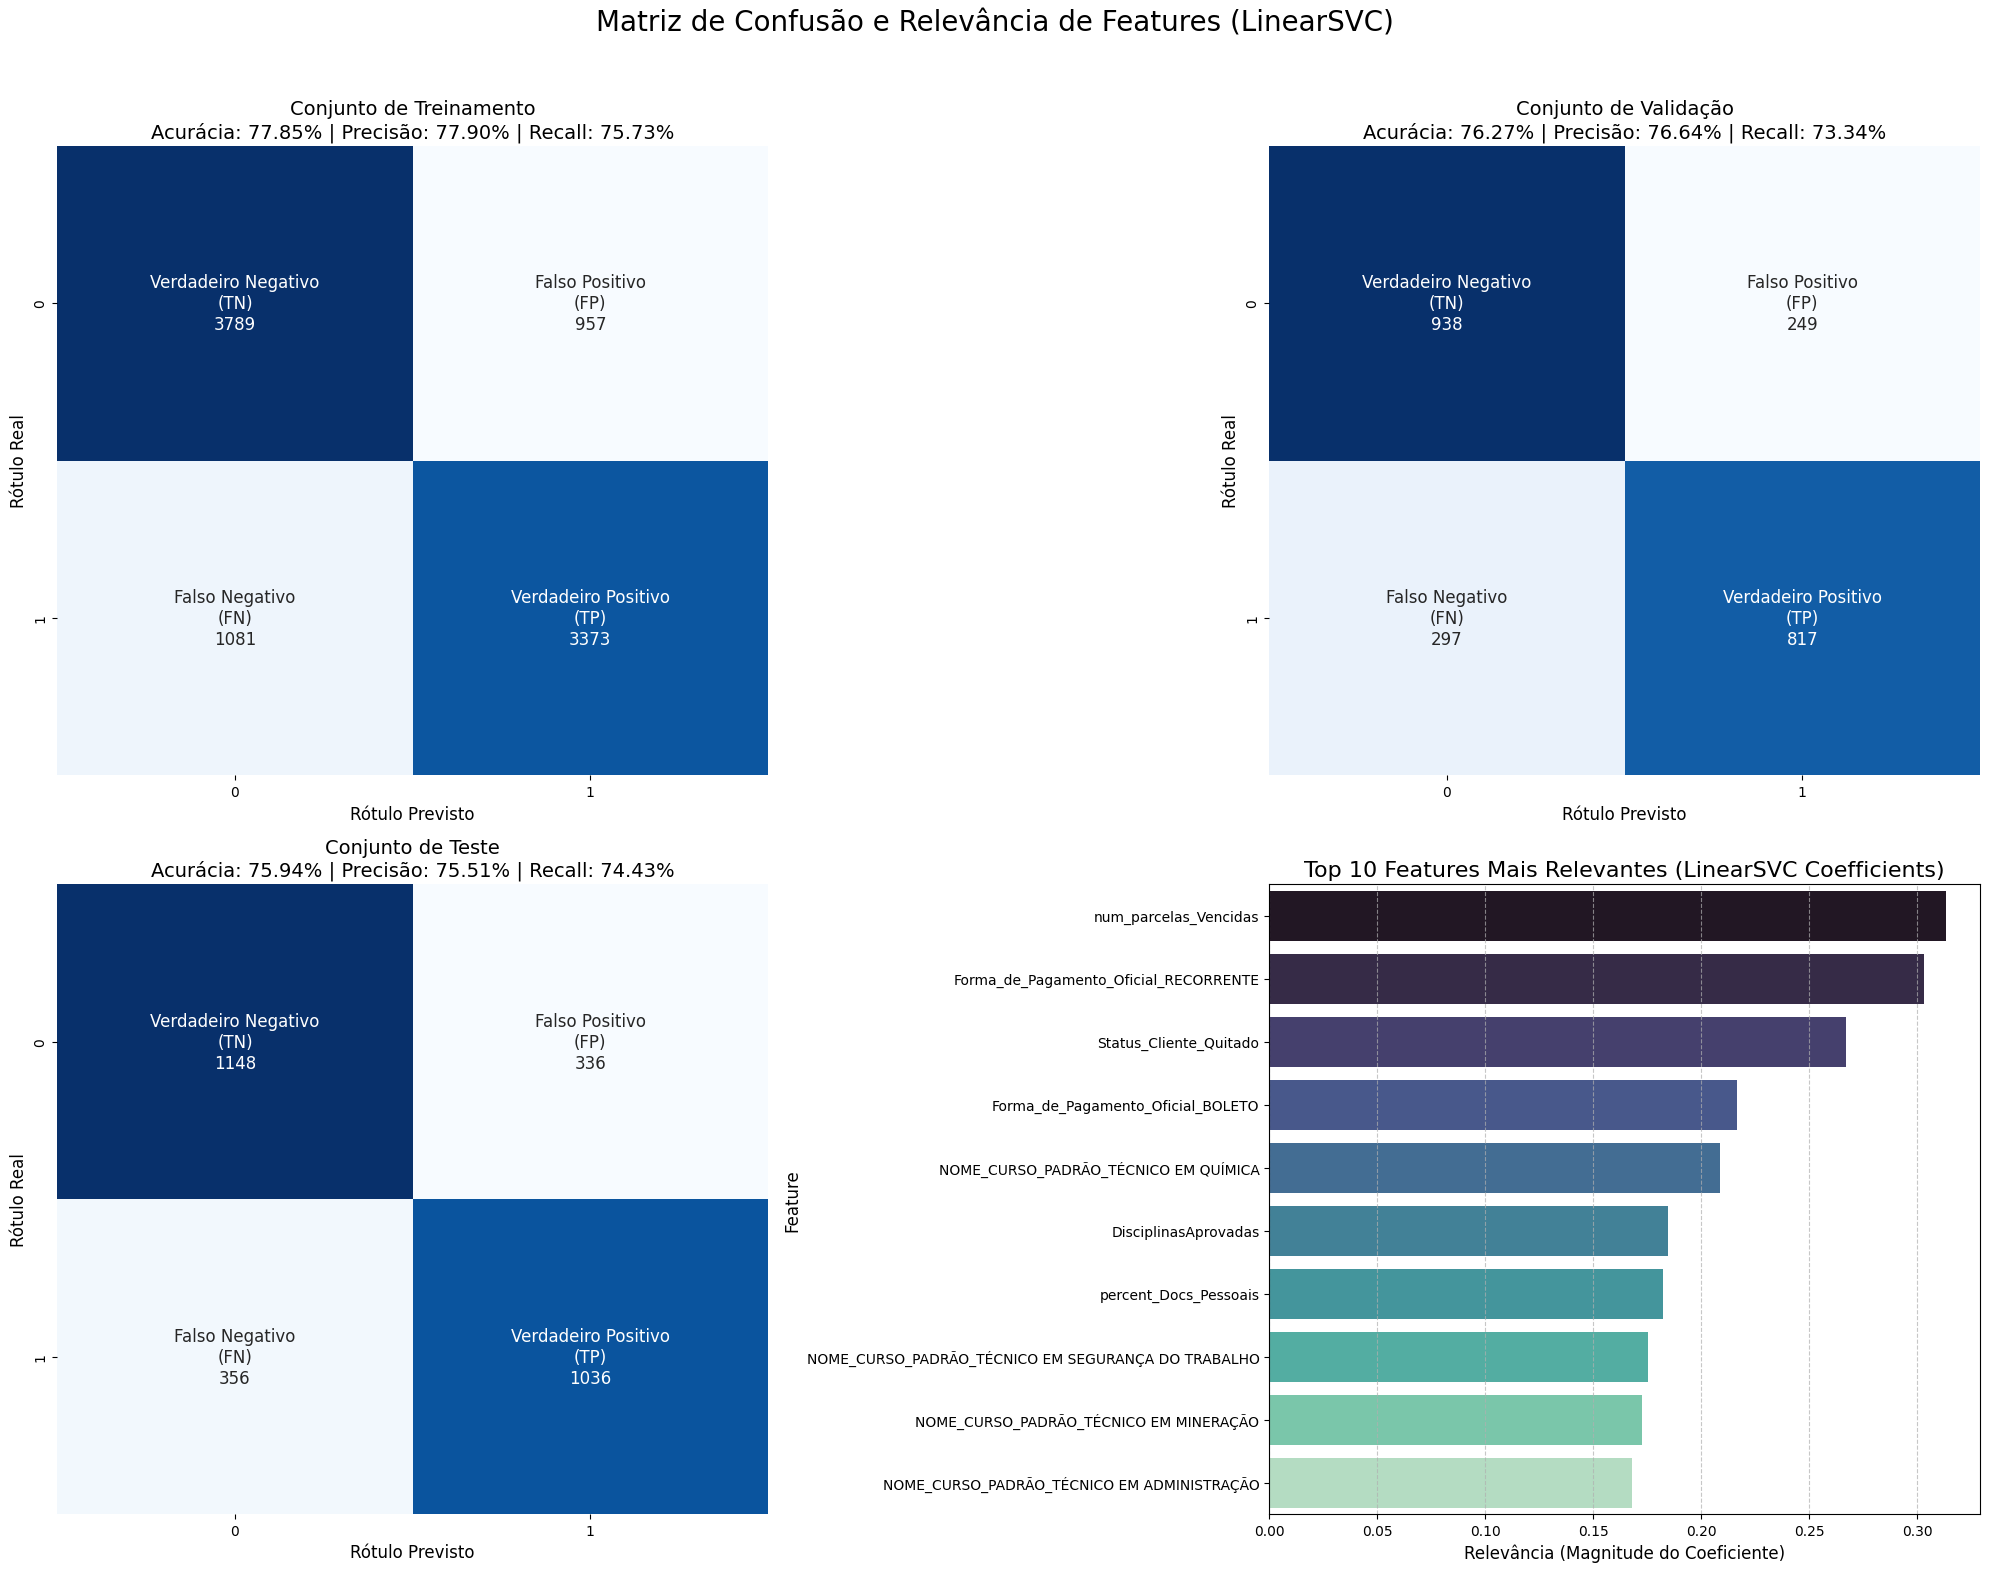

In [9]:
from sklearn.svm import LinearSVC  # <--- MUDANÇA PRINCIPAL: Importando LinearSVC

# --- Dimensionamento de Features (Feature Scaling) ---
# Esta parte permanece a mesma, pois é uma boa prática.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Treinamento do Modelo (Usando LinearSVC) ---
# Trocamos SVC por LinearSVC. É muito mais rápido e ideal para SVMs lineares.
# Parâmetros como 'kernel' e 'probability' não são necessários aqui.
# Usamos dual='auto' para que o scikit-learn escolha a melhor estratégia.
print("Iniciando o treinamento do modelo LinearSVC...")
svm_model = LinearSVC(random_state=42, dual='auto')
svm_model.fit(X_train_scaled, y_train)
print("Treinamento concluído.")

# --- Previsões ---
# A lógica de previsão é idêntica.
y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

# --- Função de Plotagem para uma Única Matriz (Sem alterações) ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plota uma única matriz de confusão anotada em um determinado eixo do matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Tratamento para casos onde a matriz não pode ser gerada (ex: apenas uma classe prevista)
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.\nVerifique os rótulos y_true e y_pred.',
                ha='center', va='center', fontsize=10)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return
        
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax, annot_kws={"size": 12})
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criar a Imagem Consolidada ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
# Título atualizado para refletir o modelo usado
fig.suptitle('Matriz de Confusão e Relevância de Features (LinearSVC)', fontsize=20, y=0.98)
axes = axes.ravel()

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features (Feature Importance) ---
ax_importance = axes[3]
# A lógica para obter a importância (coeficientes) é a mesma para LinearSVC.
# Usamos o valor absoluto porque a magnitude, não o sinal, indica a importância.
importances = np.abs(svm_model.coef_[0])
# Usamos X.columns pois X é o dataframe original antes da divisão.
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Criar o gráfico de barras com as 10 features mais importantes
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(10), # Seleciona apenas as 10 primeiras
    ax=ax_importance,
    palette='mako'
)

# Ajustar o título para refletir o modelo e o método
ax_importance.set_title('Top 10 Features Mais Relevantes (LinearSVC Coefficients)', fontsize=16)
ax_importance.set_xlabel('Relevância (Magnitude do Coeficiente)', fontsize=12)
ax_importance.set_ylabel('Feature', fontsize=12)
ax_importance.grid(axis='x', linestyle='--', alpha=0.7)

# Ajustar o layout e exibir o gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Starting the SVC model training...
Training completed.


/tmp/ipykernel_5136/968537785.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


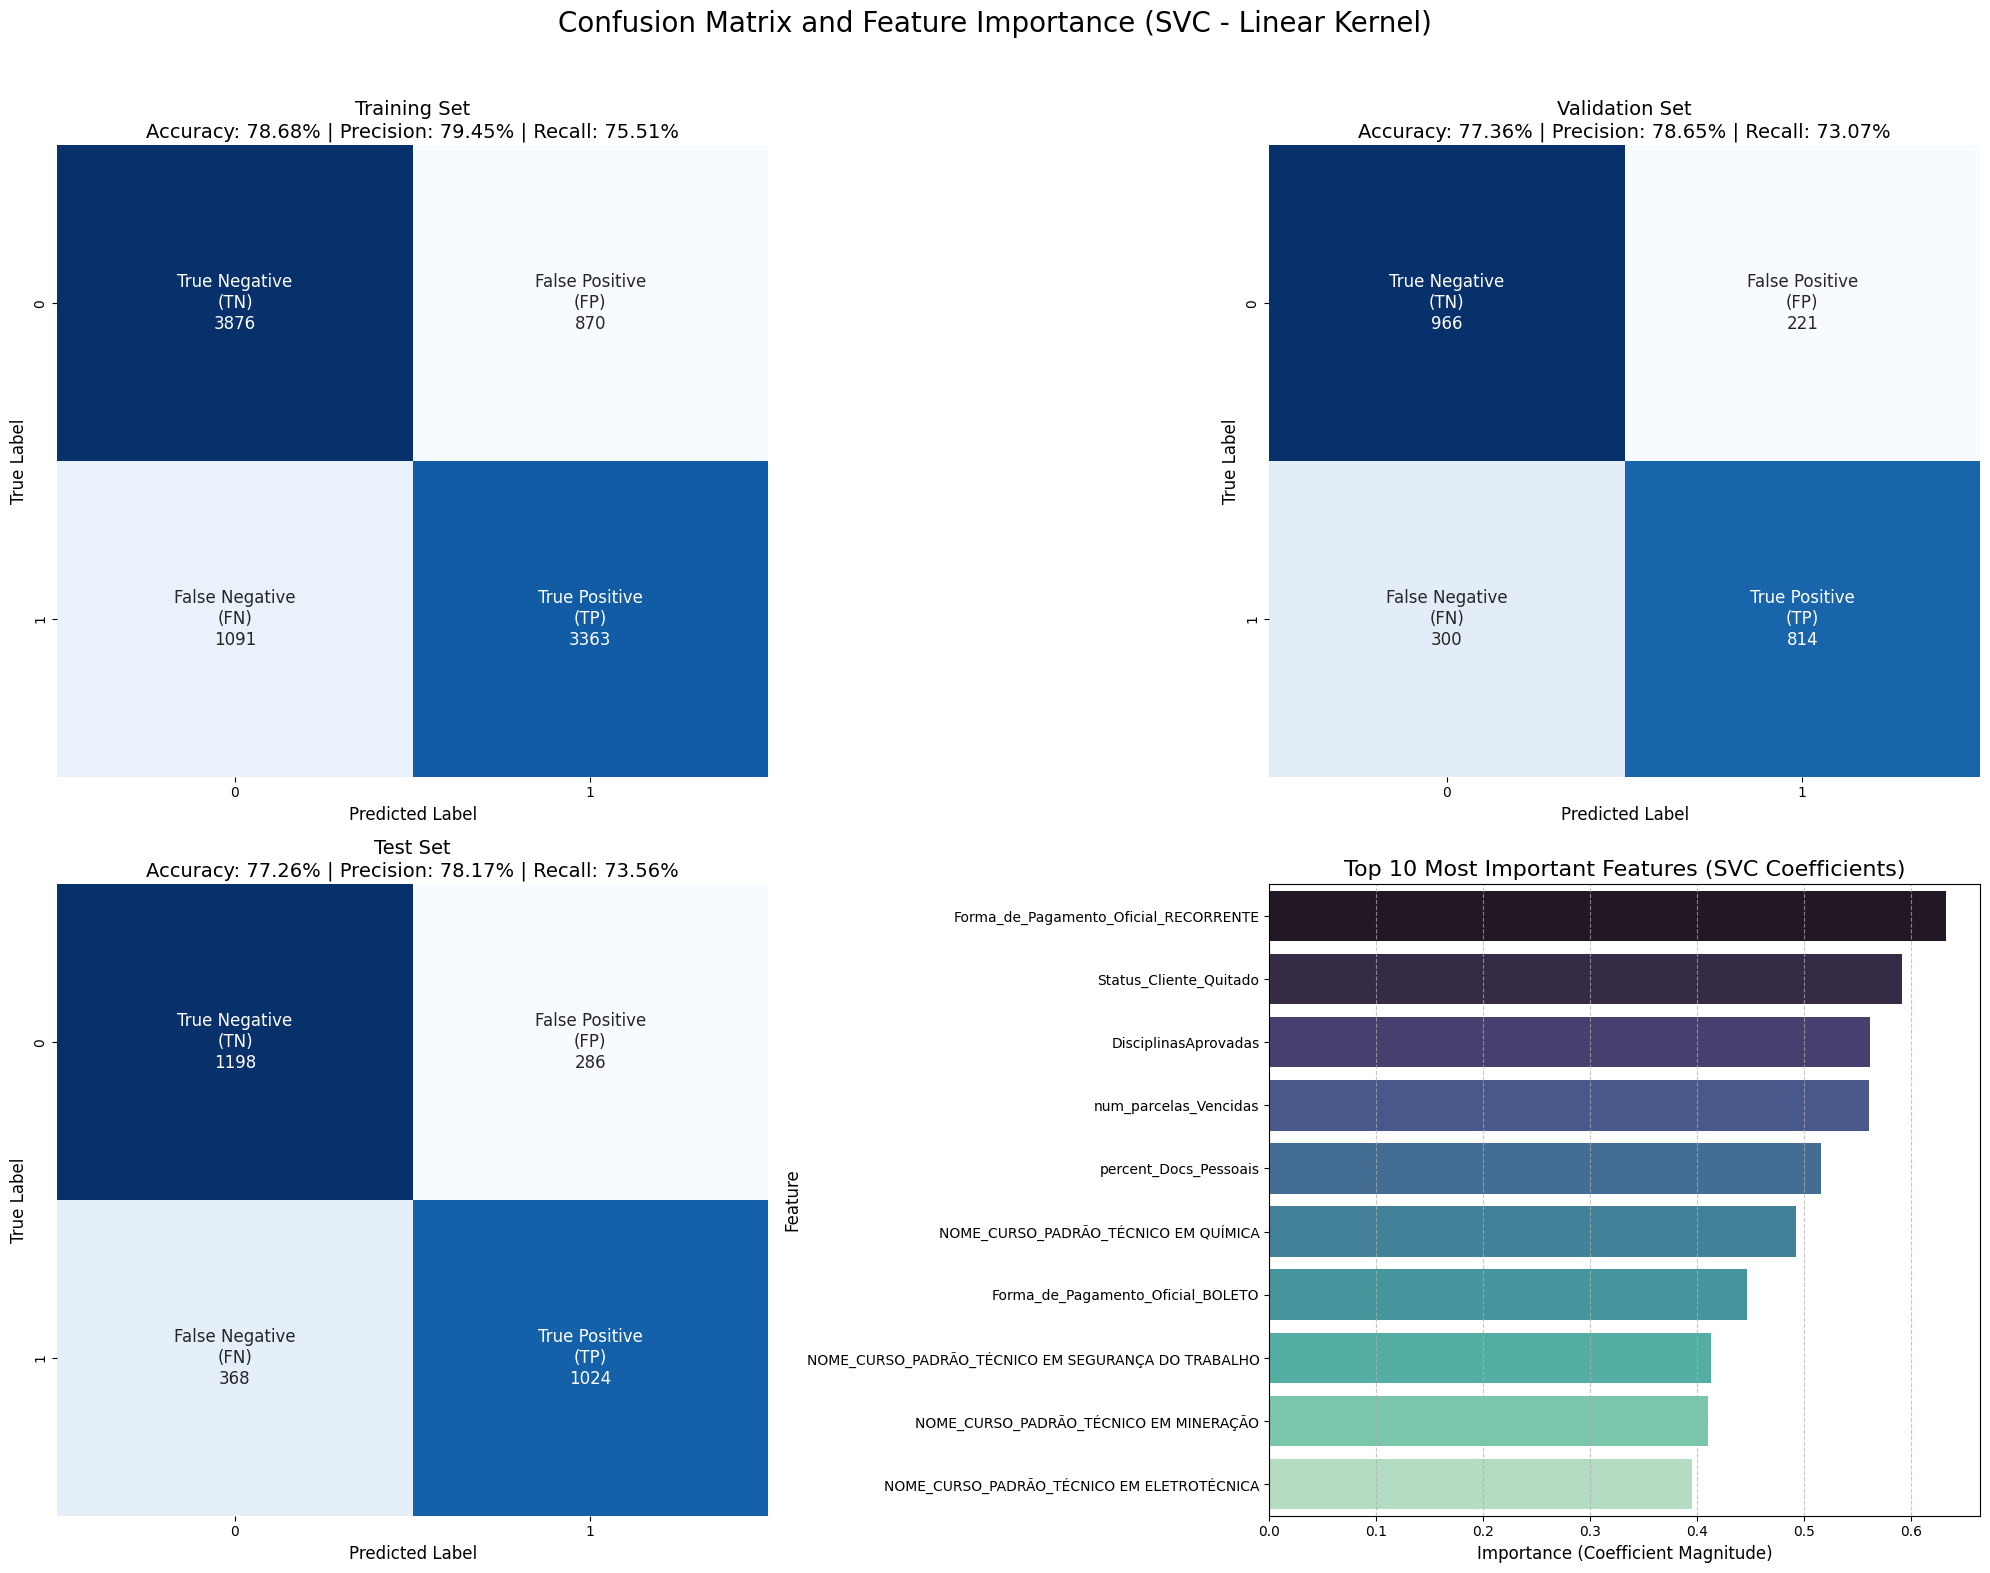

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC  # <--- MAIN CHANGE: Importing SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# --- Feature Scaling ---
# This part remains the same as it is a standard best practice for SVM.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Model Training (Using SVC with a Linear Kernel) ---
# We switched LinearSVC for SVC. To achieve a linear separation,
# we set the parameter kernel='linear'.
# Note: SVC can be more computationally intensive than LinearSVC for the same task.
print("Starting the SVC model training...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)
print("Training completed.")

# --- Predictions ---
# The prediction logic is identical.
y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

# --- Plotting Function for a Single Matrix (No changes) ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plots a single annotated confusion matrix on a given matplotlib axis.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Handles cases where a matrix cannot be generated (e.g., only one class is predicted)
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Could not generate matrix.\nCheck y_true and y_pred labels.',
                ha='center', va='center', fontsize=10)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return
        
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    labels = np.array([
        [f'True Negative\n(TN)\n{tn}', f'False Positive\n(FP)\n{fp}'],
        [f'False Negative\n(FN)\n{fn}', f'True Positive\n(TP)\n{tp}']
    ])
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax, annot_kws={"size": 12})
    subtitle = f'Accuracy: {accuracy:.2%} | Precision: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

# --- Create the Consolidated Image ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
# Updated title to reflect the model used
fig.suptitle('Confusion Matrix and Feature Importance (SVC - Linear Kernel)', fontsize=20, y=0.98)
axes = axes.ravel()

# Plot each confusion matrix
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Training Set')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Validation Set')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Test Set')

# --- Plot Feature Importance ---
ax_importance = axes[3]
# The logic to get importance (coefficients) is the same for SVC with a linear kernel.
# We use the absolute value because magnitude, not the sign, indicates importance.
importances = np.abs(svm_model.coef_[0])
# We use X.columns as X is the original dataframe before splitting.
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Create the bar chart with the top 10 most important features
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(10), # Selects only the top 10
    ax=ax_importance,
    palette='mako'
)

# Adjust the title to reflect the model and method
ax_importance.set_title('Top 10 Most Important Features (SVC Coefficients)', fontsize=16)
ax_importance.set_xlabel('Importance (Coefficient Magnitude)', fontsize=12)
ax_importance.set_ylabel('Feature', fontsize=12)
ax_importance.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/home/bard/Projects/PAD/FMF_Churn-PAD/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:21:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipykernel_5136/1155485344.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


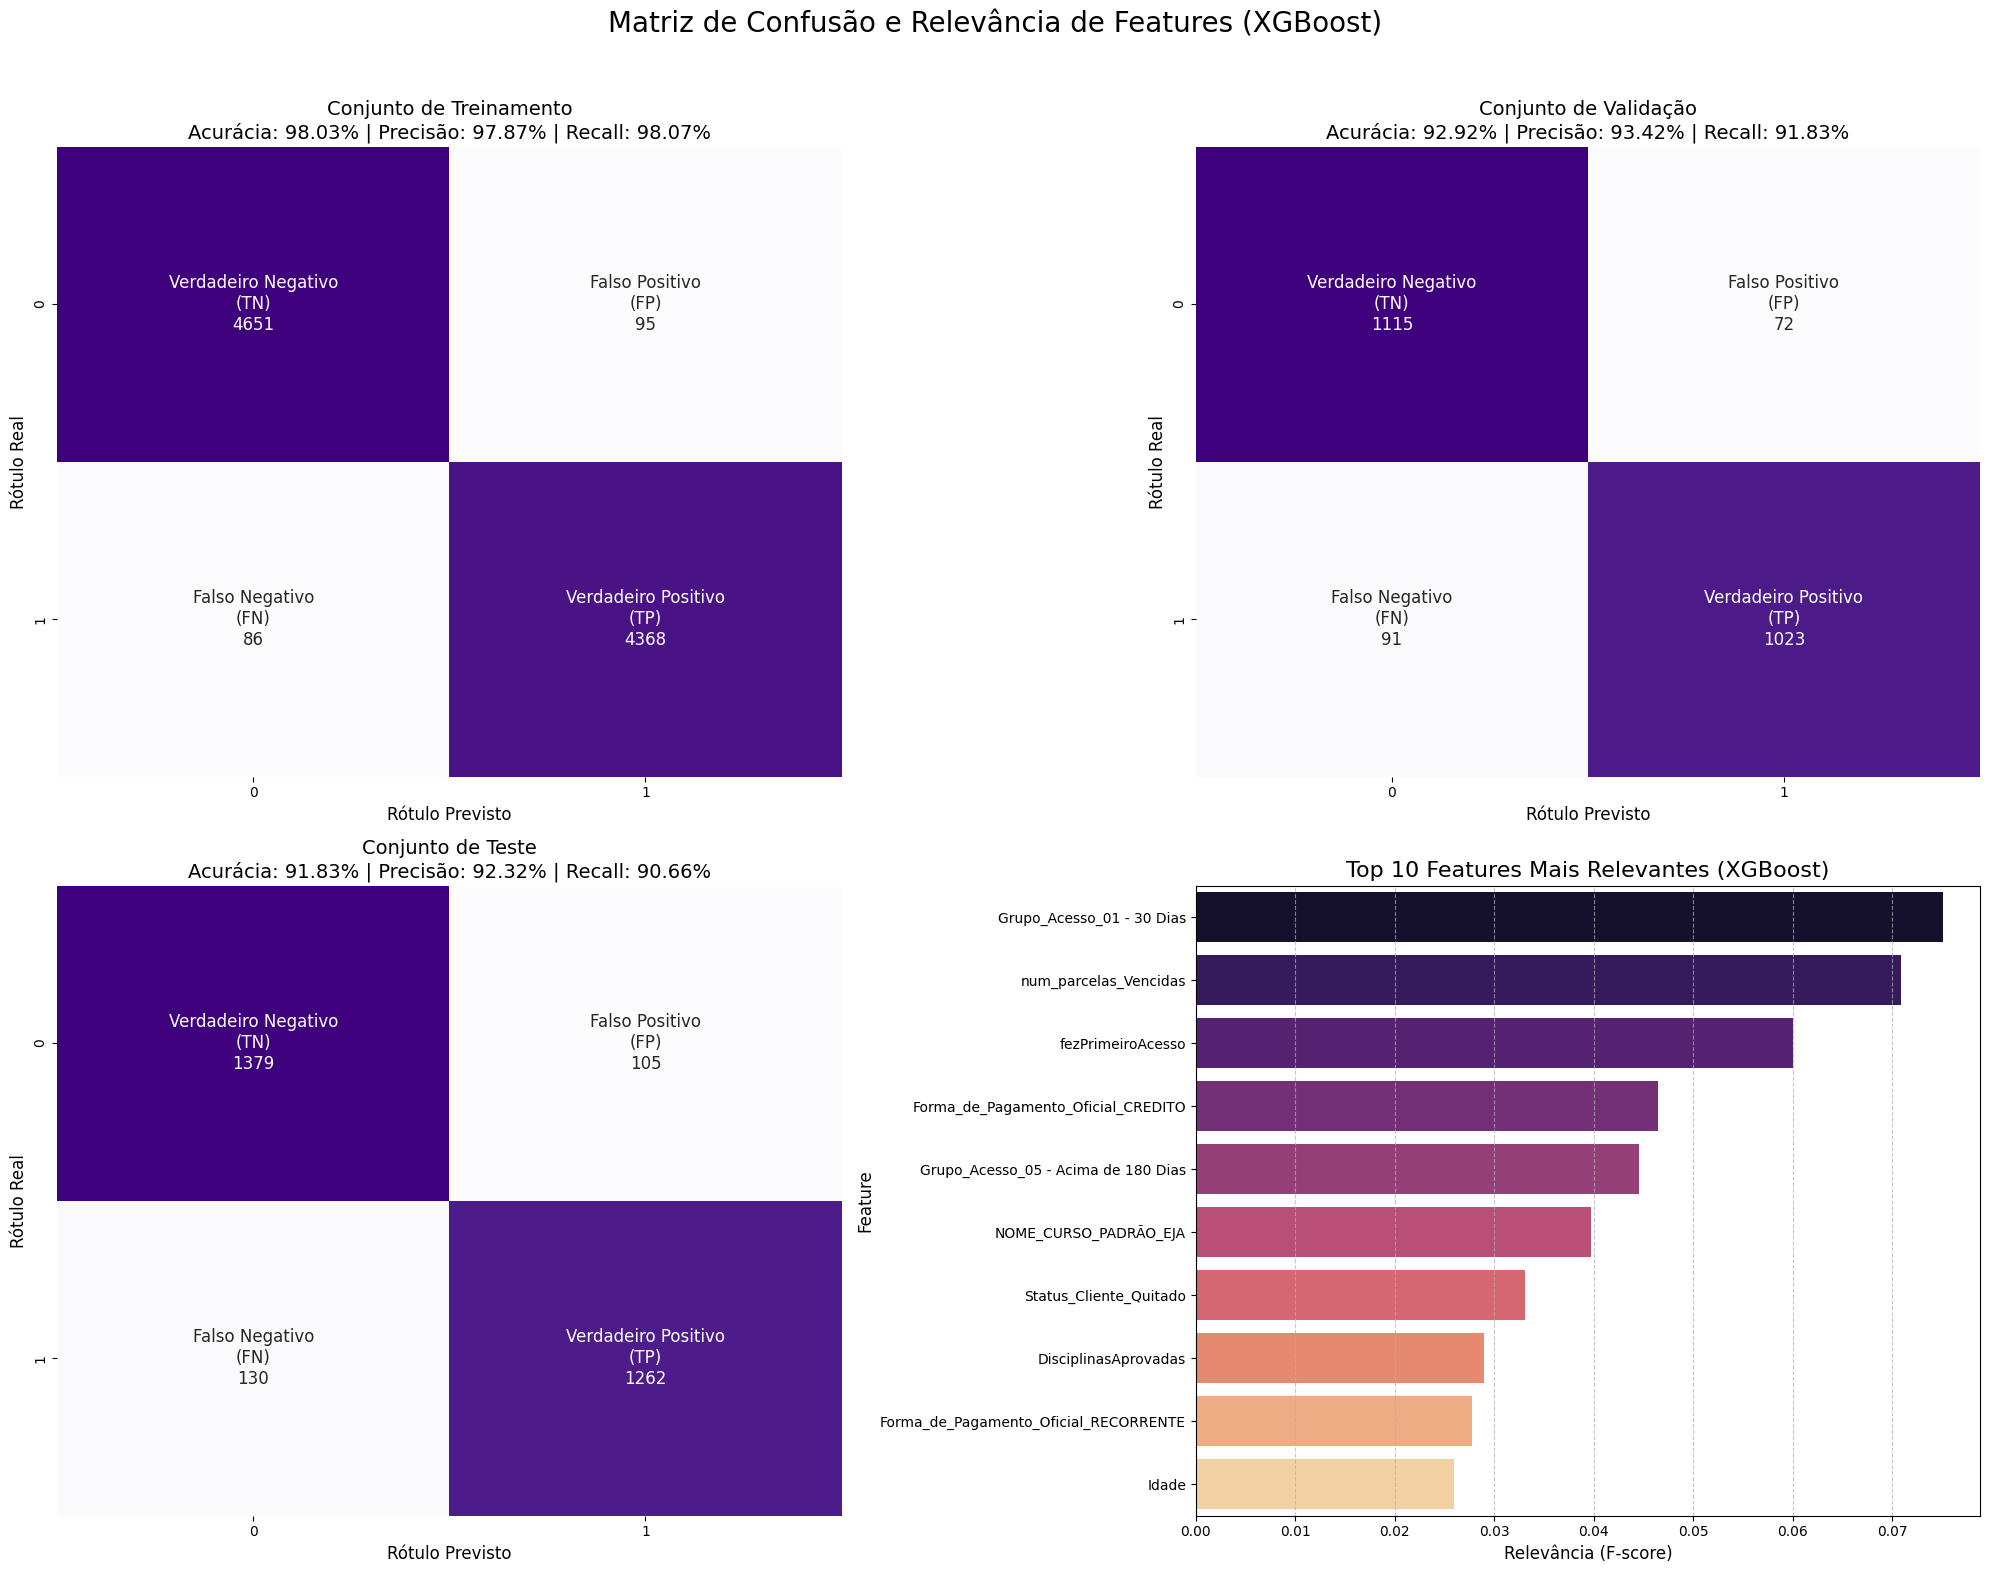

In [11]:
from xgboost import XGBClassifier
# --- Dimensionamento de Features (Feature Scaling) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Treinamento do Modelo (XGBoost) ---
# Trocamos o modelo anterior pelo XGBClassifier
# use_label_encoder=False e eval_metric='logloss' são adicionados para evitar avisos comuns.
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# --- Previsões ---
y_train_pred = xgb_model.predict(X_train_scaled)
y_val_pred = xgb_model.predict(X_val_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# --- Função de Plotagem para uma Única Matriz ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plota uma única matriz de confusão anotada em um determinado eixo do matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.\nVerifique os rótulos y_true e y_pred.', 
                ha='center', va='center', fontsize=10)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return
        
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])
    sns.heatmap(cm, annot=labels, fmt='', cmap='Purples', cbar=False, ax=ax, annot_kws={"size": 12}) # Mudado para cmap='Purples'
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criar a Imagem Consolidada ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Matriz de Confusão e Relevância de Features (XGBoost)', fontsize=20, y=0.98) # Título atualizado
axes = axes.ravel()

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features (Feature Importance) ---
ax_importance = axes[3]
# O XGBoost também possui o atributo 'feature_importances_'
importances = xgb_model.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Criar o gráfico de barras com as 10 features mais importantes
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(10), # Seleciona apenas as 10 primeiras linhas
    ax=ax_importance, 
    palette='magma' # Mudado para palette='magma'
)

# Ajustar o título para refletir a mudança
ax_importance.set_title('Top 10 Features Mais Relevantes (XGBoost)', fontsize=16) # Título atualizado
ax_importance.set_xlabel('Relevância (F-score)', fontsize=12)
ax_importance.set_ylabel('Feature', fontsize=12)
ax_importance.grid(axis='x', linestyle='--', alpha=0.7)

# Ajustar o layout e exibir o gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()